In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

from xgboost import XGBRegressor as XGB
import lightgbm
from lightgbm import LGBMRegressor as LGB

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, StackingClassifier

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues


from sklearn.metrics import mean_squared_log_error, mean_squared_error


import functools


rmse = functools.partial(mean_squared_error, squared=False)
rmsle = functools.partial(mean_squared_log_error, squared=False)


SEED=42

from src.styles import set_styles, TXT_ACC, TXT_RESET

import warnings
warnings.filterwarnings('ignore')


# ---- REPRODICIBILITY ------------------------------------------------
np.random.seed(SEED)

# ---- PANDAS ---------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,}'.format


set_styles()

C:\Users\Hawkins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CFG:
    path_train = 'data/train.csv'
    path_test = 'data/test.csv'
    target = 'Rings'

In [3]:
df_train = pd.read_csv(CFG.path_train).drop('id', axis=1)
df_train['Sex'] = df_train['Sex'].map({'I':0, 'F':1, 'M':2})
df_train

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,1,0.55,0.43,0.15,0.7715,0.3285,0.1465,0.24,11
1,1,0.63,0.49,0.145,1.13,0.458,0.2765,0.32,11
2,0,0.16,0.11,0.025,0.021,0.0055,0.003,0.005,6
3,2,0.595,0.475,0.15,0.9145,0.3755,0.2055,0.25,10
4,0,0.555,0.425,0.13,0.782,0.3695,0.16,0.1975,9
...,...,...,...,...,...,...,...,...,...
90610,2,0.335,0.235,0.075,0.1585,0.0685,0.037,0.045,6
90611,2,0.555,0.425,0.15,0.879,0.3865,0.1815,0.24,9
90612,0,0.435,0.33,0.095,0.3215,0.151,0.0785,0.0815,6
90613,0,0.345,0.27,0.075,0.2,0.098,0.049,0.07,6


# Cases that stand out from EDA

In [4]:
df_big_height = df_train.loc[df_train['Height'] > 0.3]
df_big_height

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
16384,1,0.515,0.375,1.13,0.572,0.237,0.1455,0.15,8
28651,1,0.665,0.515,0.5,1.7825,0.533,0.334,0.4285,10
54423,1,0.66,0.54,0.35,1.2635,0.5595,0.2435,0.415,16
55852,2,0.745,0.545,0.5,1.7875,0.8075,0.3935,0.565,10
56089,1,0.705,0.575,0.515,2.21,1.1075,0.4865,0.512,11
58048,1,0.635,0.495,0.5,1.2615,0.5385,0.305,0.375,11
63851,2,0.64,0.51,0.5,1.3715,0.5065,0.305,0.47,12
65464,2,0.585,0.45,1.13,1.1,0.5085,0.2425,0.28,10
77326,1,0.565,0.455,1.0,1.0145,0.5255,0.244,0.2835,8


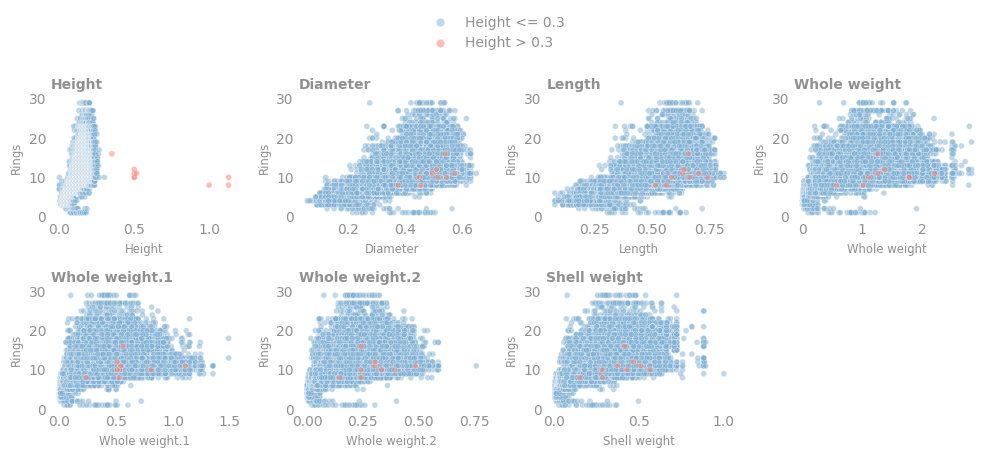

In [5]:
features = ['Height', 'Diameter', 'Length', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
axes = axes.ravel()
for f, ax in zip(features, axes[:-1]):
    df = df_train.sort_values('Height')
    sns.scatterplot(x=df[f], y=df['Rings'], ax=ax, hue=(df['Height'] > 0.3).astype(int), alpha=0.5, size=2)
    ax.set_title(f, fontsize=10)
    ax.legend().set_visible(False)

axes[-1].set_xticks([])
axes[-1].set_yticks([])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], ['Height <= 0.3', 'Height > 0.3'], loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show();

In [6]:
df_1or2rings_largerDiameter = df_train.loc[(df_train['Diameter'] > 0.3) & (df_train['Rings'] <= 2)]
df_1or2rings_largerDiameter

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
1634,2,0.545,0.43,0.14,0.7895,0.3245,0.1695,0.22,1
5547,0,0.58,0.45,0.14,0.81,0.317,0.157,0.2215,1
12728,0,0.475,0.36,0.11,0.4775,0.2115,0.0745,0.165,1
14654,0,0.53,0.41,0.11,0.6125,0.2655,0.1295,0.19,1
18602,1,0.45,0.35,0.115,0.44,0.18,0.096,0.13,1
23166,1,0.425,0.345,0.095,0.394,0.1785,0.0815,0.11,2
23199,0,0.44,0.345,0.115,0.4935,0.237,0.0845,0.13,1
23846,0,0.555,0.425,0.125,0.879,0.3355,0.217,0.2485,1
24036,0,0.45,0.325,0.115,0.3645,0.1575,0.0795,0.1165,2
25824,0,0.55,0.445,0.14,0.8145,0.427,0.1715,0.245,1


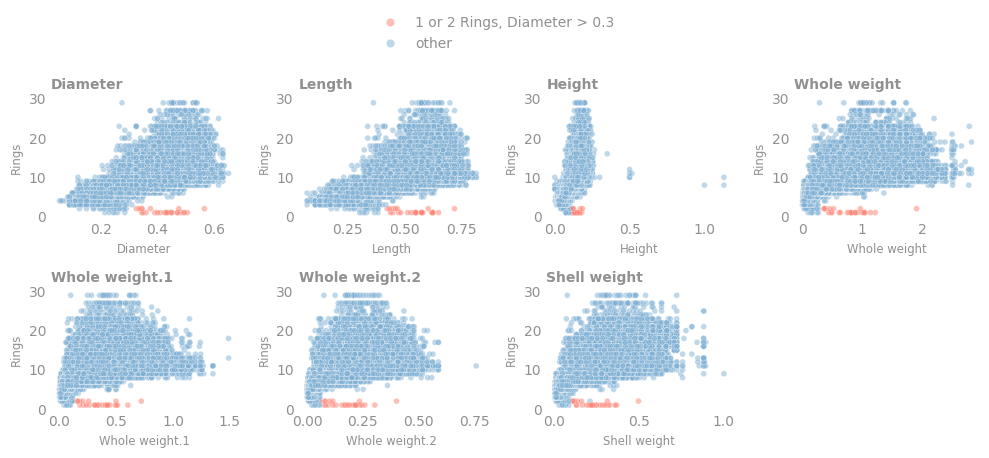

In [7]:
features = ['Diameter', 'Length', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
axes = axes.ravel()
for f, ax in zip(features, axes[:-1]):
    df = df_train
    sns.scatterplot(x=df[f], y=df['Rings'], ax=ax, hue=((df_train['Diameter'] > 0.3) & (df_train['Rings'] <= 2)).astype(int), alpha=0.5, size=2)
    ax.set_title(f, fontsize=10)
    ax.legend().set_visible(False)

axes[-1].set_xticks([])
axes[-1].set_yticks([])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend([handles[1], handles[0]], ['1 or 2 Rings, Diameter > 0.3', 'other'], loc='upper center', bbox_to_anchor=(0.5, 1.15), 
           bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show();

In [8]:
print(f'{TXT_ACC} Check predictions on subsets {TXT_RESET}')
print('\nHeight > 0.3')
print(list(df_big_height.index))
print('\n1 or 2 Rings, Diameter > 0.3')
print(list(df_1or2rings_largerDiameter.index))

 Check predictions on subsets 

Height > 0.3
[16384, 28651, 54423, 55852, 56089, 58048, 63851, 65464, 77326]

1 or 2 Rings, Diameter > 0.3
[1634, 5547, 12728, 14654, 18602, 23166, 23199, 23846, 24036, 25824, 26481, 26515, 33890, 35845, 42270, 42385, 42936, 43801, 51498, 52204, 55740, 61631, 64766, 69870, 79417, 85983]


# Automatic outlier detection

Used methods:
- Isolation forest
- Local outlier factor
- cleanlab OutOfDistribution

Summary: Automatic methods haven't picked out any definitive outliers

In [9]:
clf = IsolationForest(n_estimators=50, contamination=0.01)
preds = clf.fit_predict(df_train) 
df_outliers = pd.DataFrame(-0.5*(preds - 1), columns=['iso_forest'])
df_outliers['iso_forest'].value_counts()

iso_forest
-0.0    89708
1.0       907
Name: count, dtype: int64

In [10]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
preds = clf.fit_predict(df_train)
df_outliers['lof'] = -0.5*(preds - 1)
df_outliers['lof'].value_counts()

lof
-0.0    89708
1.0       907
Name: count, dtype: int64

Fitting OOD estimator based on provided features ...


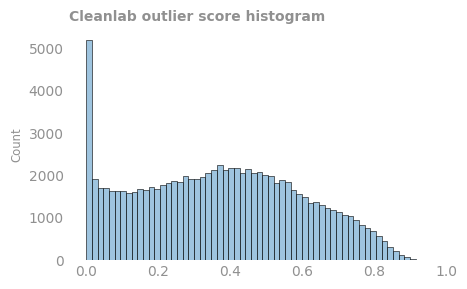

In [11]:
ood = OutOfDistribution()
train_ood_features_scores = ood.fit_score(features=df_train)

_, ax = plt.subplots(1,1, figsize=(5, 3))
sns.histplot(train_ood_features_scores, ax=ax)
ax.set_title('Cleanlab outlier score histogram', fontsize=10)
plt.show();

In [12]:
df_outliers['cleanlab_out'] = (train_ood_features_scores > 0.8).astype(int) 
df_outliers[['iso_forest', 'lof', 'cleanlab_out']].sum(axis=1).value_counts()

0.0    86900
1.0     3622
2.0       93
Name: count, dtype: int64